# QRS Detector

This notebook implements the actual QRS Detector. In this notebook there are two networks present, a fully conected feed forward network and a recurrent network, with the aim of comparing the two models and verifying which is more indicated for the type of data we have

In [0]:
# importing required libraries
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt
import pickle as pkl
import random
import math

#!pip install wfdb
import wfdb
from wfdb.processing import find_local_peaks
from wfdb.processing import compare_annotations

In [0]:
from google.colab import drive
#drive.mount('/content/drive/')
from glob import glob

In [3]:
!ls drive/'My Drive'/'Colab Notebooks'/processed_data
main_path = 'drive/My Drive/Colab Notebooks/processed_data/'
weights_path = 'drive/My Drive/Colab Notebooks/network_weights/'

Test  Training


## Sampling Function

The objective is to retrieve a random cropping of both the signal and the target from all files specified for the training/validation set. This helps us have a more well-versed dataset for training and validating our models.

In [0]:
# auxiliary function
# extracts from a long np-array (2-rows) a (2-rows)-random segment with a fixed length (seqL*ninputs)
def selectFrom1ecg(ecgBdata, seqL, ninputs, feed_forward = True, training = True, testing = False):
    """
    x: An array with vairous files, channels and examples
    seqL:  number of timesteps to be used in recurrent nn
    ninput : is number of inputs in each timestep
    file_indexes: A list of the file indexes for training or validation set
    """
    segmentL  = seqL * ninputs
    numChan = 3
    
    if(training):
        random_file_idx = random.randint(0, 57)
    else:
        random_file_idx = random.randint(0, 9)
    
    if(testing):
        random_file_idx = random.randint(0, 48)
    
    inpOutSegment = tf.random_crop(ecgBdata[random_file_idx],[numChan, segmentL])

    
    if(feed_forward):
        channelII = inpOutSegment[0,:]
        channelV1 = inpOutSegment[1,:]
        target = inpOutSegment[2,:]
        inputs = tf.concat((channelII, channelV1), axis = -1)
        return inputs,target
    else:
        transposed = tf.transpose(inpOutSegment)
        
        inputs = transposed[:, :-1]
        target = transposed[:, -1]
        inputs = tf.reshape(inputs, (seqL, -1))
        
        # We need to re-transpose the target to turn int back into a one-row vector
        target = tf.transpose(target)
                
        return inputs, target

## Dataset array creation

In this section we create the main dataset array containing all the training files. Each file has two input signals (channelII and channelV1) and a target signal.

In [0]:
dataset_array = []

files_not_to_read = [4,17,35,44,57,72,74]
index_counter = 0
for i in range(1, 76):
    
    if i not in files_not_to_read:
        file_path = f"Training/I{i:02}"
        file_path = main_path + file_path
        file_data = pkl.load(open(file_path, "rb"))        
        index_counter = index_counter + 1
        
        info = [file_data["channelII"], file_data["channelV1"], file_data["label"]]
        info = np.array(info)
        info = info.astype(np.float32)
        dataset_array.append(info)

ecgs_array = np.array(dataset_array)

## Test dataset array creation

In this section we create the test dataset array containing all the test files. Each file has two input signals ("MLII","V1", which correspond to signals "II" and "V1" in the training dataset) and a target signal.

In [6]:
test_dataset_array = []

files_not_to_read = [110, 120, 204, 206, 211, 216, 218, 229]
files_not_to_read = files_not_to_read + list(range(125,200)) + list(range(224,228))

index_counter = 0
for i in range(100, 235):
    
    if i not in files_not_to_read:
        file_path = f"Test/{i}"
        file_path = main_path + file_path
        file_data = pkl.load(open(file_path, "rb"))        
        index_counter = index_counter + 1
        
        info = [file_data["channelII"], file_data["channelV1"], file_data["label"]]
        info = np.array(info)
        info = info.astype(np.float32)
        test_dataset_array.append(info)

test_ecgs_array = np.array(test_dataset_array)

# Test dataset length is not a multiple of 2*ninputs*seqL(rnn) which causes problems when we want to
# transpose the data as before, so we discard the last 2000 points 
# The test dataset will then have the same length as the training dataset
lenRecords = test_ecgs_array.shape[2]
new_length = int(math.floor(lenRecords/5400))*5400
test_ecgs_array = test_ecgs_array[:,:,:new_length]

650000
648000


In [7]:
# number of examples
N = ecgs_array.shape[2]

# Sampling frequency
fs = 360

# For each timestep we give ninputs
ninputs = int(0.2*fs)

# Sequence length (number of timesteps)
seqL = int((5 * 360)/ninputs) # Using a 5 second window sequence

print('ninputs = ',ninputs)
print('seqL = ',seqL)
print('ninputs*seqL = ',ninputs*seqL)

# training data for feed forward network
# Create efficient training sequences
trainData = tf.data.Dataset.from_tensors(ecgs_array[:len(ecgs_array) - 10, :, :])
trainData = trainData.map(lambda x:  selectFrom1ecg(x, seqL, ninputs, training = True))
trainData = trainData.repeat()  # Repeat the input indefinitely.
batchSize = 8
trainData = trainData.batch(batchSize)

valData = tf.data.Dataset.from_tensors(ecgs_array[len(ecgs_array) - 10:, :, :])
valData = valData.map(lambda x:  selectFrom1ecg(x, seqL, ninputs, training = False))
valData = valData.repeat()  # Repeat the input indefinitely.
batchSize = 8
valData = valData.batch(batchSize)

# test data for feed forward network (here we don't need to leave out the 10 files)
testData = tf.data.Dataset.from_tensors(test_ecgs_array)
testData = testData.map(lambda x:  selectFrom1ecg(x, seqL, ninputs, training = False, testing = True))
testData = testData.repeat()  # Repeat the input indefinitely.
batchSize = 8
testData = testData.batch(batchSize)


# Creating Training and Validation datasets with the correct shape for a Recurrent neural network
# The sequence length for the recurrent neural network can be about 3 times greater than for the feed
# forward neural net
seql_rnn = 3 * seqL

print('ninputs*seqL(rnn) = ',ninputs*seql_rnn)

trainData_rnn = tf.data.Dataset.from_tensors(ecgs_array[:len(ecgs_array) - 10, :, :])
trainData_rnn = trainData_rnn.map(lambda x:  selectFrom1ecg(x, seql_rnn, ninputs, training = True, feed_forward = False))
trainData_rnn = trainData_rnn.repeat()  # Repeat the input indefinitely.
batchSize_rnn = 8
trainData_rnn = trainData_rnn.batch(batchSize_rnn)

valData_rnn = tf.data.Dataset.from_tensors(ecgs_array[len(ecgs_array) - 10:, :, :])
valData_rnn = valData_rnn.map(lambda x:  selectFrom1ecg(x, seql_rnn, ninputs, training = False, feed_forward = False))
valData_rnn = valData_rnn.repeat()  # Repeat the input indefinitely.
batchSize_rnn = 8
valData_rnn = valData_rnn.batch(batchSize_rnn)


# test data for feed forward network (here we don't need to leave out the 10 files)
testData_rnn = tf.data.Dataset.from_tensors(test_ecgs_array)
testData_rnn = testData_rnn.map(lambda x:  selectFrom1ecg(x, seql_rnn, ninputs, training = False, feed_forward = False, testing = True))
testData_rnn = testData_rnn.repeat()  # Repeat the input indefinitely.
batchSize = 8
testData_rnn = testData_rnn.batch(batchSize)

ninputs =  72
seqL =  25
ninputs*seqL =  1800
Instructions for updating:
Colocations handled automatically by placer.
ninputs*seqL(rnn) =  5400


# Recurrent neural network

In this subsection we define the architecture for the RNN. We are using 4 LSTM layers with GPU support.
After fitting our RNN we save the model weights to be able to reuse them without retraining the network.

In [39]:
numLstmUnits = 320

rnnModel = tf.keras.Sequential()
rnnModel.add(layers.CuDNNLSTM(units=numLstmUnits, return_sequences=True, input_shape = (seql_rnn, 2 * ninputs)))         
rnnModel.add(layers.CuDNNLSTM(units=numLstmUnits, return_sequences=True))
rnnModel.add(layers.CuDNNLSTM(units=numLstmUnits, return_sequences=True))         
rnnModel.add(layers.CuDNNLSTM(units=numLstmUnits, return_sequences=True))
rnnModel.add(layers.TimeDistributed(layers.Dense(ninputs)))
rnnModel.add(layers.Reshape((seql_rnn * ninputs, )))

rnnModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])

#rnnModel.fit(trainData_rnn,  epochs=10, steps_per_epoch=1000, validation_data=valData_rnn, validation_steps=100)

Epoch 1/10
1000/1000 [==============================] - 28s 28ms/step - loss: 0.0116 - mean_absolute_error: 0.0251 - val_loss: 0.0113 - val_mean_absolute_error: 0.0278
Epoch 2/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.0111 - mean_absolute_error: 0.0293 - val_loss: 0.0114 - val_mean_absolute_error: 0.0531
Epoch 3/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.0076 - mean_absolute_error: 0.0343 - val_loss: 0.0088 - val_mean_absolute_error: 0.0397
Epoch 4/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.0031 - mean_absolute_error: 0.0219 - val_loss: 0.0115 - val_mean_absolute_error: 0.0320
Epoch 5/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.0019 - mean_absolute_error: 0.0141 - val_loss: 0.0117 - val_mean_absolute_error: 0.0277
Epoch 6/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.0018 - mean_absolute_error: 0.0118 - val_loss: 0.0115 - val_mean_absolute_error:

In [0]:
# Saving the network weights
weights_file_path_7layers = weights_path + 'RNN_weights_7layers.h5'
weights_file_path = weights_path + 'RNN_weights.h5'
rnnModel.save_weights(weights_file_path)

In [0]:
rnnModel.load_weights(weights_file_path)

## Predict - RNN

This section is dedicated to generate the predictions of our RNN model. We first consider ten batches and obtain the predictions for them.

In [0]:
#output = rnnModel.predict(testData_rnn,steps=1000)
#print(output.shape)

In [0]:
def get_preds_targets(tf_dataset,model):
  predictions = []
  targets = []
  nbatches = 10

  try:
    iterator = tf_dataset.make_initializable_iterator()
    next_element = iterator.get_next()

    for i in range(nbatches):
      with tf.Session() as sess:
        sess.run(iterator.initializer)
        inp, targ = sess.run(next_element)
        targets.append(targ)
        print(f"Getting batch {i}")
      output = model.predict(inp)
      predictions.append(output)

  except:
    print('something wrong!')
    pass
  
  return predictions, targets

In [77]:
predictions, targets = get_preds_targets(testData_rnn, rnnModel)
targets1D = np.reshape(targets,(nbatches*batchSize_rnn*seql_rnn * ninputs))
predictions1D = np.reshape(predictions,(nbatches*batchSize_rnn*seql_rnn * ninputs))

Getting batch 0
Getting batch 1
Getting batch 2
Getting batch 3
Getting batch 4
Getting batch 5
Getting batch 6
Getting batch 7
Getting batch 8
Getting batch 9


## Postprocessing

The predictions of the RNN network are processed to eliminate false peaks (oscillations below a certain threshold). We then use the function find_local_peaks to obtain the peak positions. However, since this function gives false peaks in regions where the signal is flat, we filter its result with the same threshold as before.

In [0]:
def get_peaks(predictions1D,targets1D):
  # First use a threshold to eliminate some smaller peaks
  thresh = 0.5
  peaks = np.where(predictions1D>thresh, predictions1D, 0)

  # Find local peaks in filtered predictions
  peak_locs = find_local_peaks(peaks,8)

  # Filter peak locations with condition that value of signal there must be 
  peak_locs_above_th = [p for p in peak_locs if peaks[p] > thresh]

  peaks_targets1D = np.where(targets1D>thresh, targets1D, 0)
  # Find local peaks in filtered predictions
  targets_peak_locs = find_local_peaks(peaks_targets1D,8)
  targets_peak_locs_above_th = [p for p in targets_peak_locs if peaks_targets1D[p] > thresh]

  targets_peak_locs_above_th = np.array(targets_peak_locs_above_th)
  peak_locs_above_th = np.array(peak_locs_above_th)
  
  return peak_locs_above_th, targets_peak_locs_above_th

Finding peak indexes for plotting purposes

In [70]:
peak_locs_above_th, targets_peak_locs_above_th = get_peaks(predictions1D,targets1D)
peak_locs_above_th

array([ 49553,  52696,  74591,  78528,  78680,  83058,  84919,  85622,
       131358, 133343, 136519, 137218, 175327, 177237, 184278, 208469,
       208625, 210629, 223231, 225196, 238926, 241229, 249631, 255811,
       258954, 262479, 316958, 350927, 375830, 389557, 391548, 393448,
       415551])

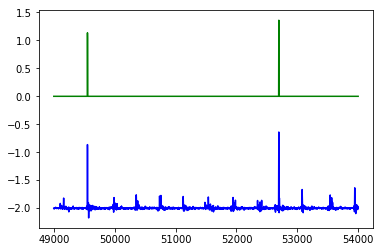

In [46]:
t = range(nbatches*batchSize_rnn*seql_rnn*ninputs)
plt.plot(t[49000:54000],predictions1D[49000:54000]-2,'b',t[49000:54000],peaks[49000:54000],'g')

## Compare predicted peaks with annotations

We now compare our predicted peaks (after postprocessing) with the labelled peaks to determine the number of peaks correctly classified by our network.

In [47]:
comparitor = compare_annotations(targets_peak_locs_above_th, peak_locs_above_th, 5, signal=None)
comparitor.print_summary()

1249 reference annotations, 33 test annotations

True Positives (matched samples): 31
False Positives (unmatched test samples: 2
False Negatives (unmatched reference samples): 1218

Specificity: 0.0248 (31/1249)
Positive Predictivity: 0.9394 (31/33)
False Positive Rate: 0.0606 (2/33)


# Feedforward network

The architecture of the Feedforward network is designed below, similarly to what was done for the RNN.

In [58]:
ffwdModel = tf.keras.Sequential()
ffwdModel.add(layers.Dense(64, activation='relu',input_shape=(2*seqL*ninputs,)))
ffwdModel.add(layers.Dense(64, activation='relu'))
ffwdModel.add(layers.Dense(64, activation='relu'))
ffwdModel.add(layers.Dense(seqL*ninputs))

ffwdModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
ffwdModel.fit(trainData,  epochs=15, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

Epoch 1/15
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0128 - mean_absolute_error: 0.0272 - val_loss: 0.0100 - val_mean_absolute_error: 0.0260
Epoch 2/15
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0126 - mean_absolute_error: 0.0283 - val_loss: 0.0102 - val_mean_absolute_error: 0.0325
Epoch 3/15
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0124 - mean_absolute_error: 0.0308 - val_loss: 0.0102 - val_mean_absolute_error: 0.0352
Epoch 4/15
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0122 - mean_absolute_error: 0.0316 - val_loss: 0.0102 - val_mean_absolute_error: 0.0351
Epoch 5/15
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0123 - mean_absolute_error: 0.0317 - val_loss: 0.0102 - val_mean_absolute_error: 0.0338
Epoch 6/15
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0122 - mean_absolute_error: 0.0315 - val_loss: 0.0104 - val_mean_absolute_error: 0.0352
Epoc

In [0]:
# Saving the network weights
ffwd_weights_file_path = weights_path + 'FFWD_weights.h5'
ffwdModel.save_weights(ffwd_weights_file_path)

In [0]:
ffwdModel.load_weights(ffwd_weights_file_path)

## Predict - FFWD

This process is analog to what was done for the RNN.

In [78]:
ffwd_predictions, ffwd_targets = get_preds_targets(testData, ffwdModel)
ffwd_targets1D = np.reshape(ffwd_targets,(nbatches*batchSize*seqL * ninputs))
ffwd_predictions1D = np.reshape(ffwd_predictions,(nbatches*batchSize*seqL * ninputs))

Getting batch 0
Getting batch 1
Getting batch 2
Getting batch 3
Getting batch 4
Getting batch 5
Getting batch 6
Getting batch 7
Getting batch 8
Getting batch 9


## Posprocessing

Postprocessing of the predicted peaks.

In [80]:
ffwd_peak_locs_above_th, ffwd_targets_peak_locs_above_th = get_peaks(ffwd_predictions1D,ffwd_targets1D)
ffwd_peak_locs_above_th

array([63253, 72253])

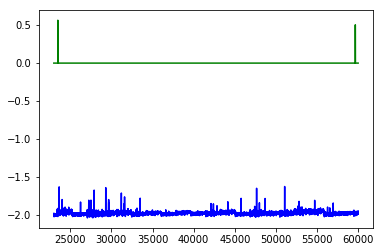

In [81]:
ffwd_t = range(nbatches*batchSize*seqL*ninputs)
plt.plot(ffwd_t[23000:60000],ffwd_predictions1D[23000:60000]-2,'b',ffwd_t[23000:60000],ffwd_peaks[23000:60000],'g')

## Compare predicted peaks with annotations

In [82]:
ffwd_comparitor = compare_annotations(ffwd_targets_peak_locs_above_th, ffwd_peak_locs_above_th, 5, signal=None)
ffwd_comparitor.print_summary()

393 reference annotations, 2 test annotations

True Positives (matched samples): 2
False Positives (unmatched test samples: 0
False Negatives (unmatched reference samples): 391

Specificity: 0.0051 (2/393)
Positive Predictivity: 1.0000 (2/2)
False Positive Rate: 0.0000 (0/2)
